In [117]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *

In [118]:
np.random.seed(0)
def get_surgery_time(mean,std):
    sh,sc = (mean/std)**2,std**2/mean
    return np.random.gamma(shape=sh,scale=sc)

In [145]:
#problem parameters
specs = ['CARD','GASTRO','GYN','MED','ORTHO','URO']

surgery_data = {'CARD':[99.0,53.0],'GASTRO':[132.0,76.0],'GYN':[78.0,52.0],'MED':[75.0,32.0],'ORTHO':[142.0,58.0],'URO':[72.0,38.0]}

blocks = {'CARD':[2,6,16,28,32,33],'GASTRO':[1,8,14,15,22,27,34],'GYN':[4,11,12,18,19,24,25,30,35],'MED':[17,36],'ORTHO':[3,9,10,21,23,29,37],'URO':[5,7,13,20,26,31,38]}
block_len = [8 for i in range(32)]+[60 for i in range(len(specs))]
n_blocks = len(block_len)

n_surgeries = 100
percent_surg = {'CARD':14,'GASTRO':18,'GYN':28,'MED':5,'ORTHO':17,'URO':18}
surgeries = {}
tot = 0
for i in specs[:len(specs)-1]:
    surgeries[i] = round(n_surgeries*percent_surg[i]/100.0)
    tot += surgeries[i]
surgeries[specs[-1]] = n_surgeries-tot

surgery_nums = {}
t = 0
for s in specs:
    surgery_nums[s] = [t,t+surgeries[s]-1]
    t = t+surgeries[s]
    
print(surgeries)
print(surgery_nums)
print(block_len)

{'CARD': 14, 'GASTRO': 18, 'GYN': 28, 'MED': 5, 'ORTHO': 17, 'URO': 18}
{'CARD': [0, 13], 'GASTRO': [14, 31], 'GYN': [32, 59], 'MED': [60, 64], 'ORTHO': [65, 81], 'URO': [82, 99]}
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 60, 60, 60, 60, 60, 60]


In [169]:
cib = np.array([[0.0 for _ in range(n_blocks)] for _ in range(n_surgeries)]) # block costs for each patient for different surgeries
for s in specs:
    for i in range(surgery_nums[s][0],surgery_nums[s][1]):
        costs = sorted([np.random.randint(low=1,high=10)*50 for _ in range(len(blocks[s])-1)])
        #costs = [np.random.randint(low=1,high=5)*100 for _ in range(len(blocks[s])-1)]
        f = 0
        for b in blocks[s][:len(blocks[s])-1]:
            cib[i,b-1] = costs[f]

            f += 1
print(cib)


[[  0. 100.   0. ...   0.   0.   0.]
 [  0.  50.   0. ...   0.   0.   0.]
 [  0. 150.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [170]:
dummy_cost = 1000 #assigning dummy high cost to dummy slot for each type of surgery
for s in specs:
    for i in range(surgery_nums[s][0],surgery_nums[s][1] + 1): #added one so that Last OR only get high dummy cost.
        b = blocks[s][-1]
        cib[i,b-1] = dummy_cost


cob = np.array([10.0 for _ in range(n_blocks)])
cgb = np.array([10.0/1.5 for _ in range(n_blocks-len(specs))]+[0.0 for _ in range(len(specs))])
print(cib)

[[   0.  100.    0. ...    0.    0.    0.]
 [   0.   50.    0. ...    0.    0.    0.]
 [   0.  150.    0. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...    0.    0. 1000.]
 [   0.    0.    0. ...    0.    0. 1000.]
 [   0.    0.    0. ...    0.    0. 1000.]]


In [171]:
#block and surgery of a speciality fesibility
p = [[0 for _ in range(n_blocks)] for _ in range(n_surgeries)]
p = np.array(p)
t = 0
for s in specs:
    for i in range(surgeries[s]):
        for b in blocks[s]:
            p[t,b-1] = 1
        t += 1

In [172]:
n_scenarios = 10**3
avg_model = ConcreteModel()
avg_model.y = Var(RangeSet(n_surgeries),RangeSet(n_blocks),domain=Binary)
avg_model.o = Var(RangeSet(n_blocks),RangeSet(n_scenarios),domain=NonNegativeReals)
avg_model.g = Var(RangeSet(n_blocks),RangeSet(n_scenarios),domain=NonNegativeReals)

avg_model.atmost1 = ConstraintList()
for i in range(n_surgeries):
    avg_model.atmost1.add(expr=sum(avg_model.y[i+1,b] for b in range(1,n_blocks+1))==1)

avg_model.specfeas = ConstraintList()
for i in range(n_surgeries):
    for b in range(n_blocks):
        avg_model.specfeas.add(expr=avg_model.y[i+1,b+1] <= p[i,b])

avg_model.ogcons = ConstraintList()
for n in range(n_scenarios):
    t = 0
    for s in specs:
        for b in blocks[s]:
            avg_model.ogcons.add(expr=avg_model.o[b,n+1]-avg_model.g[b,n+1] == sum(get_surgery_time(surgery_data[s][0],surgery_data[s][1])*avg_model.y[i+1,b] for i in range(surgery_nums[s][0],surgery_nums[s][1]+1))-block_len[b-1])

avg_model.cost = Objective(expr=sum(sum(avg_model.y[i+1,b+1]*cib[i,b] for i in range(n_surgeries)) for b in range(n_blocks))+(sum(cob[b]*avg_model.o[b+1,n+1]+cgb[b]*avg_model.g[b+1,n+1] for b in range(n_blocks) for n in range(n_scenarios)))/n_scenarios,sense=minimize)

In [173]:
path = 'G:\SOFTWARES\cbcSolve\cbc.exe'
opt = SolverFactory('cbc', executable = path)
result = opt.solve(avg_model,tee=True)
print("Solver status :",result.solver.status)
print("Solver Termination condition :", result.solver.termination_condition)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Nov 24 2021 

command line - G:\SOFTWARES\cbcSolve\cbc.exe -printingOptions all -import C:\Users\gokul\AppData\Local\Temp\tmpmkz4ue95.pyomo.lp -stat=1 -solve -solu C:\Users\gokul\AppData\Local\Temp\tmpmkz4ue95.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 38095 (-3806) rows, 70712 (-9089) columns and 787707 (-12894) elements
Statistics for presolved model
Original problem has 3800 integers (3800 of which binary)
Presolved problem has 712 integers (712 of which binary)
==== 31 zero objective 16 different
==== absolute objective values 16 different
==== for integers 31 zero objective 14 different
==== for integers absolute objective values 14 different
===== end objective counts


Problem has 38095 rows, 70712 columns (70681 with objective) and 787707 elements
There are 70000 singletons with objective 
Column breakdown:
70000 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf

In [174]:
l = [[] for _ in range(n_blocks)]
for b in range(n_blocks):
    for i in range(n_surgeries):
        if avg_model.y[i+1,b+1].value > 0.0:
            l[b].append(i)

for i in range(len(l)):
    print("Block :",i+1, 'Surgeries',l[i])
    

Block : 1 Surgeries [14, 16, 17, 20, 21, 22, 23, 24, 25, 28, 30]
Block : 2 Surgeries [0, 1, 2, 3, 4, 5, 7, 9, 11]
Block : 3 Surgeries [65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 80]
Block : 4 Surgeries [32, 33, 34, 35, 36, 37, 39, 40, 42, 44, 45, 46, 48, 50, 51, 55, 58]
Block : 5 Surgeries [83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 97, 98]
Block : 6 Surgeries [6, 10]
Block : 7 Surgeries [82]
Block : 8 Surgeries [18, 19, 29]
Block : 9 Surgeries [76, 78]
Block : 10 Surgeries [77]
Block : 11 Surgeries [38, 41, 52, 56, 57]
Block : 12 Surgeries [53, 54]
Block : 13 Surgeries [96]
Block : 14 Surgeries [27]
Block : 15 Surgeries [15]
Block : 16 Surgeries [8]
Block : 17 Surgeries [60, 61, 62, 63, 64]
Block : 18 Surgeries [43]
Block : 19 Surgeries [47]
Block : 20 Surgeries [89]
Block : 21 Surgeries [69]
Block : 22 Surgeries [26]
Block : 23 Surgeries [79]
Block : 24 Surgeries [49]
Block : 25 Surgeries [59]
Block : 26 Surgeries [99]
Block : 27 Surgeries [31]
Block : 28 Surgeries [12]
Block : 29 

In [62]:
blocks

{'CARD': [2, 6, 16, 28, 32, 33],
 'GASTRO': [1, 8, 14, 15, 22, 27, 34],
 'GYN': [4, 11, 12, 18, 19, 24, 25, 30, 35],
 'MED': [17, 36],
 'ORTHO': [3, 9, 10, 21, 23, 29, 37],
 'URO': [5, 7, 13, 20, 26, 31, 38]}

In [10]:
for i in specs:
    print(i, blocks[i])

CARD [2, 6, 16, 28, 32, 33]
GASTRO [1, 8, 14, 15, 22, 27, 34]
GYN [4, 11, 12, 18, 19, 24, 25, 30, 35]
MED [17, 36]
ORTHO [3, 9, 10, 21, 23, 29, 37]
URO [5, 7, 13, 20, 26, 31, 38]


In [11]:
os = [[] for _ in range(n_blocks)]
gs = [[] for _ in range(n_blocks)]

for b in range(n_blocks):
    for n in range(n_scenarios):
        os[b].append(avg_model.o[b+1,n+1].value)
        gs[b].append(avg_model.g[b+1,n+1].value)

os = np.array(os)
gs = np.array(gs)

In [24]:
os

array([[741.79823  , 469.26219  , 330.00245  , ..., 790.67647  ,
        512.91472  , 597.89231  ],
       [375.24885  , 424.19647  , 497.0094   , ..., 625.3861   ,
        443.37805  , 446.41509  ],
       [349.2864   , 517.72492  , 381.86114  , ..., 354.22472  ,
        202.63514  , 516.67791  ],
       ...,
       [108.04987  ,  90.365812 ,  48.808204 , ...,  93.638815 ,
         47.495263 ,  69.097544 ],
       [163.41829  ,  58.046802 ,  36.590163 , ..., 105.95035  ,
        211.64397  ,  20.515757 ],
       [ 96.838824 ,   5.2045656,  65.945022 , ...,  64.534367 ,
         54.532173 ,  73.820286 ]])

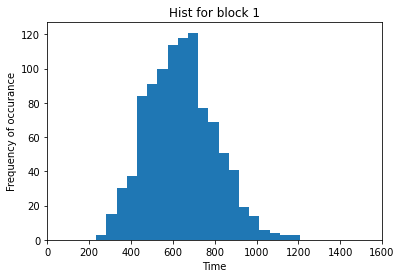

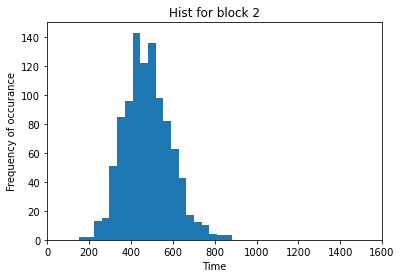

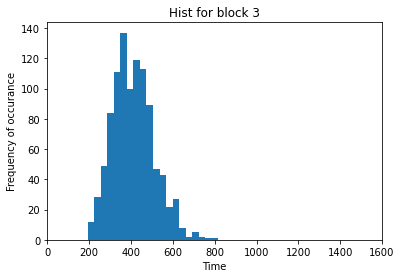

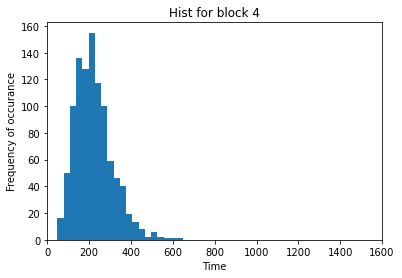

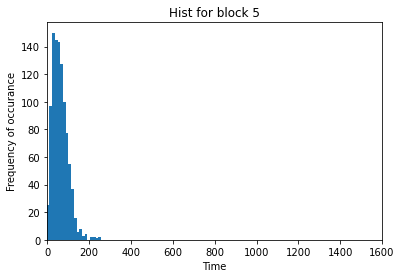

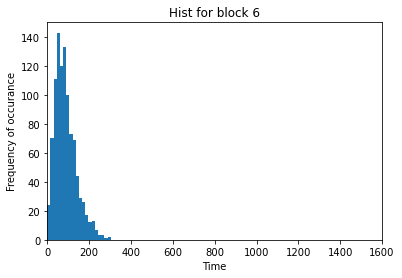

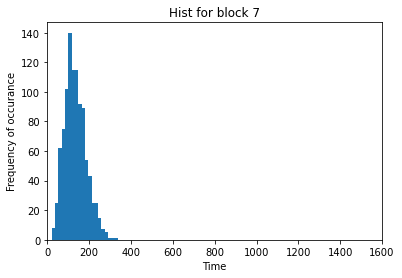

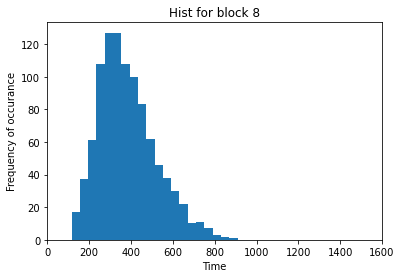

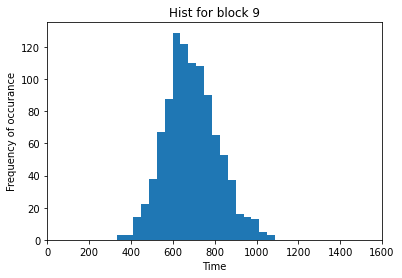

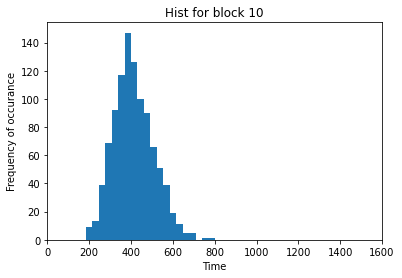

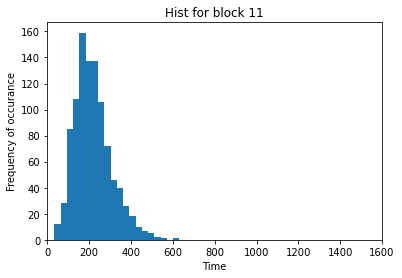

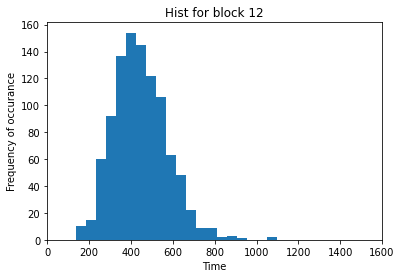

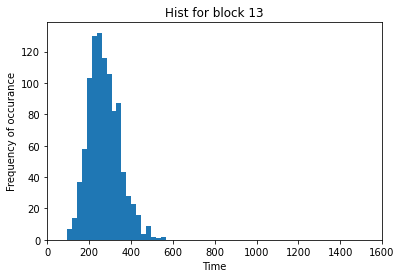

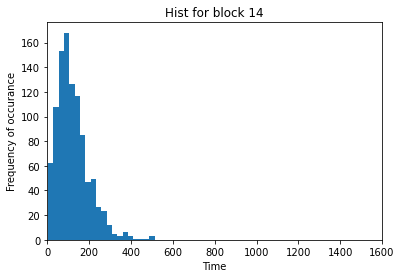

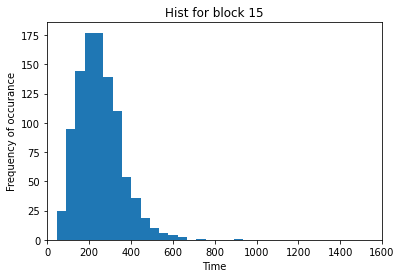

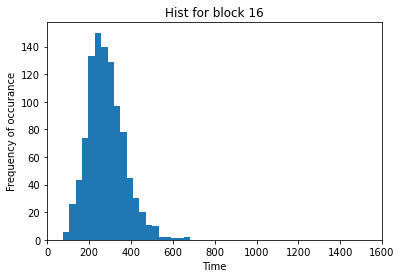

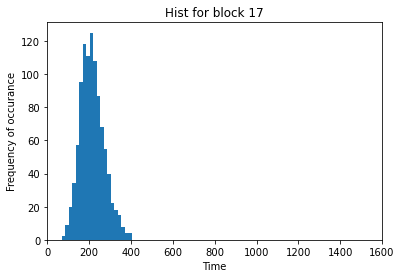

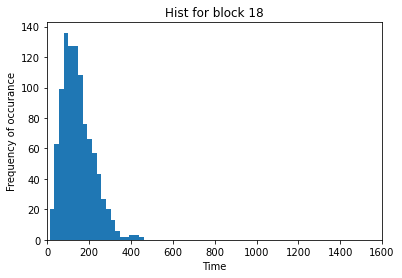

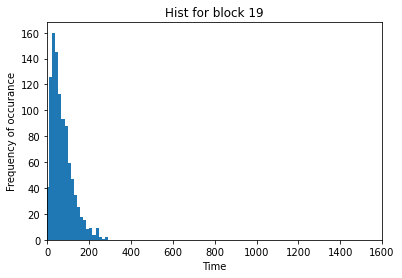

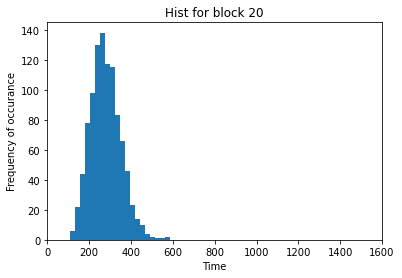

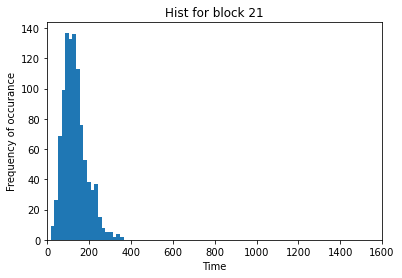

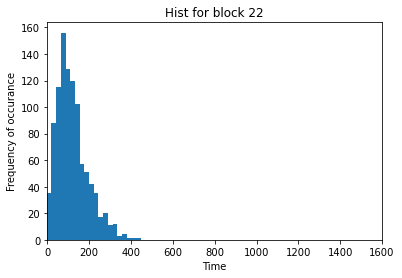

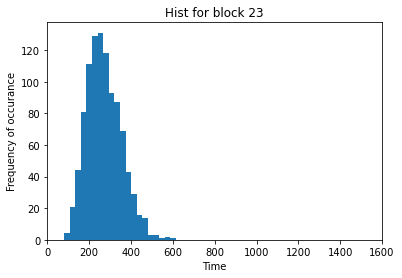

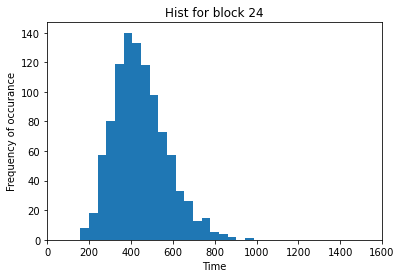

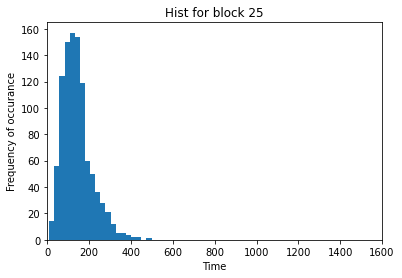

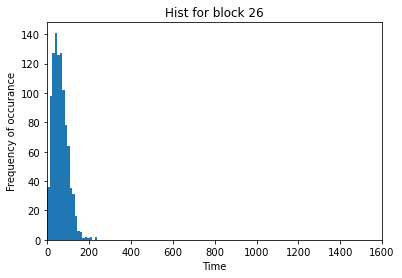

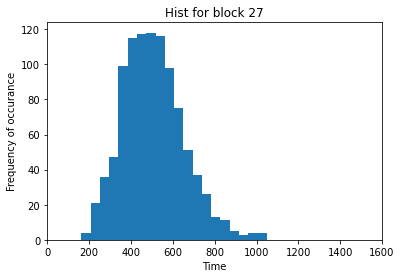

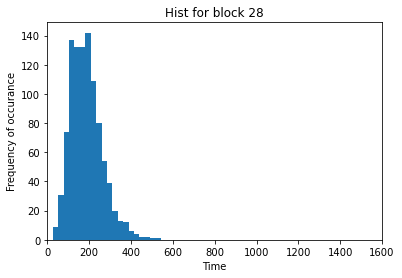

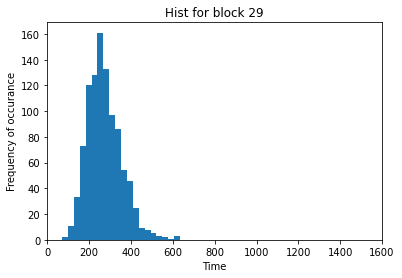

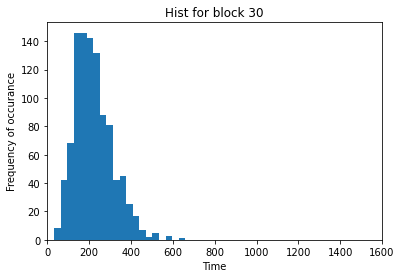

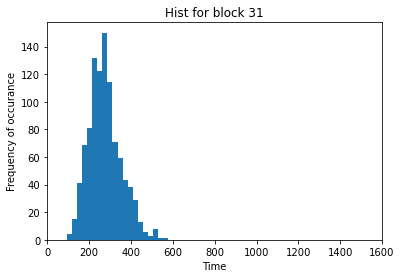

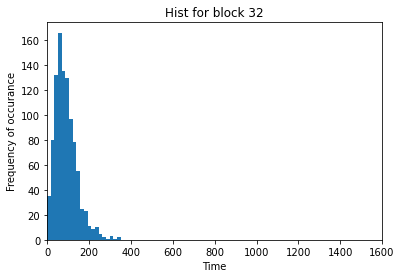

In [147]:
overtime = os-gs

for b in range(n_blocks-len(specs)): #added labels
    plt.figure()
    plt.title("Hist for block "+str(b+1))
    plt.hist(overtime[b],bins=20)
    plt.xlim(0,1600)
    plt.xlabel('Time')
    plt.ylabel('Frequency of occurance')
    plt.show()

In [13]:
cib

array([[ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  4.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0., 20.],
       [ 0.,  0.,  0., ...,  0.,  0., 20.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [14]:
assignments = np.array([[0.0 for _ in range(n_blocks)] for _ in range(n_surgeries)])
for i in range(n_surgeries):
    for b in range(n_blocks):
        assignments[i,b] = avg_model.y[i+1,b+1].value
        
#plt.figure(figsize=(20,20))
#plt.imshow(assignments,interpolation='nearest')
assignments

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [69]:
np.array([_ +1 for _ in range(n_surgeries)])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

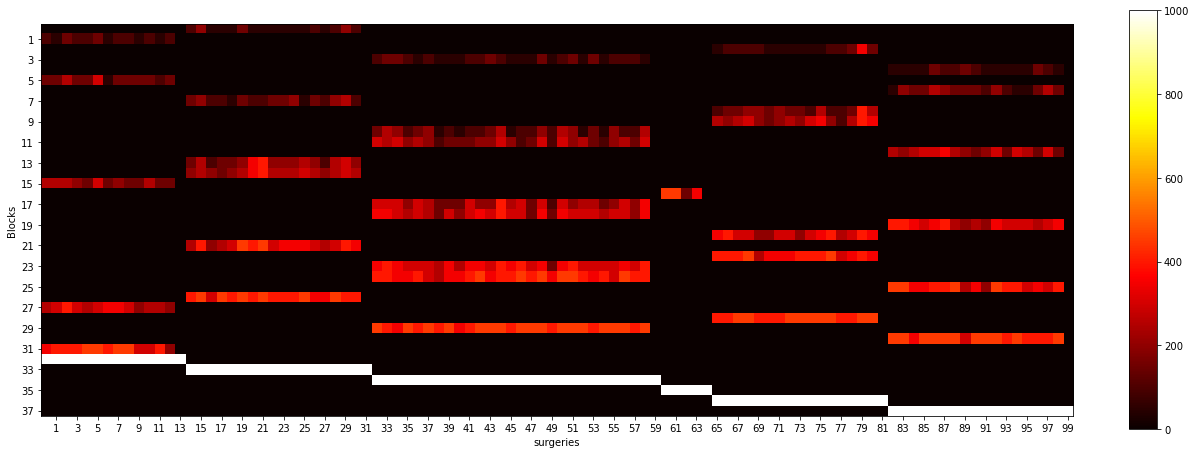

In [201]:
fig,ax1 = plt.subplots(figsize=(20,20))
cax = ax1.imshow(cib.T,interpolation='nearest', cmap = 'hot') #added color bar, labels, tics
fig.colorbar(cax, fraction = 0.025, aspect = 15)
plt.xlabel('Surgeries') 
plt.ylabel('Blocks')

plt.yticks(np.arange(min(np.array([(_ +1)for _ in range(n_blocks)])), max(np.array([(_ +1)for _ in range(n_blocks)])), 2.0))
plt.xticks(np.arange(min(np.array([(_ +1)for _ in range(n_surgeries)])), max(np.array([(_ +1)for _ in range(n_surgeries)])), 2.0))

#plt.yticks(np.array([(_ +1)for _ in range(n_blocks)]))
#plt.xticks(np.array([_ +1 for _ in range(n_surgeries)]))
plt.show()

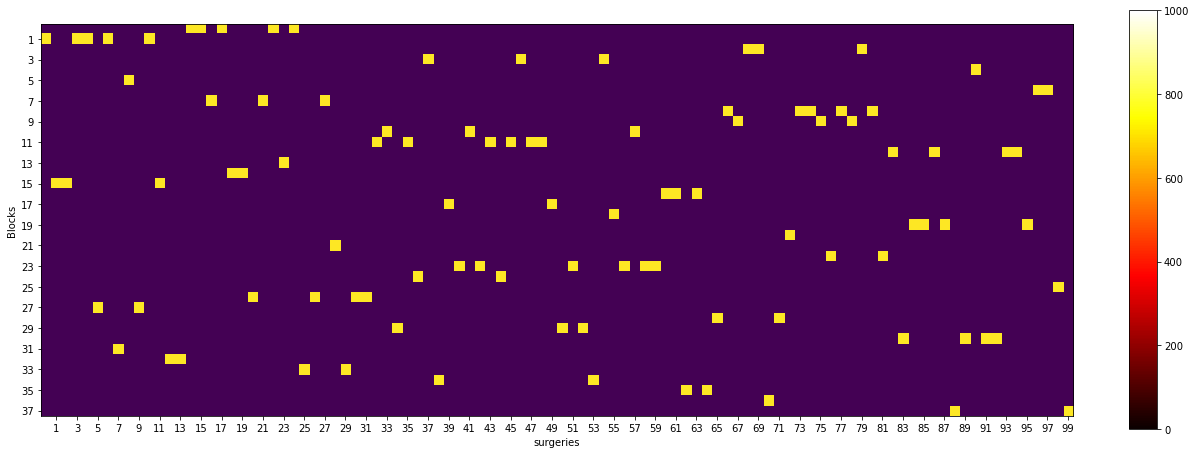

In [203]:
fig,ax2 = plt.subplots(figsize=(20,20))
ax2.imshow(assignments.T,interpolation='nearest')
fig.colorbar(cax, fraction = 0.025, aspect = 15)
plt.xlabel('Surgeries')
plt.ylabel('Blocks')
plt.yticks(np.arange(min(np.array([(_ +1)for _ in range(n_blocks)])), max(np.array([(_ +1)for _ in range(n_blocks)])), 2.0))
plt.xticks(np.arange(min(np.array([(_ +1)for _ in range(n_surgeries)])), max(np.array([(_ +1)for _ in range(n_surgeries)])), 2.0))
plt.show()

In [16]:
cib.shape

(100, 38)

In [17]:
cib[:2,:32]

array([[0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 8., 0., 0., 0., 8.],
       [0., 4., 0., 0., 0., 8., 0., 0., 0., 0., 0., 0., 0., 0., 0., 8.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 8., 0., 0., 0., 8.]])